# Prepare Observational Data
Download and clean observational data so that we can compute timelags from it and compare to simulations. 

We need to do the following tasks for each map:
1. Download the level 1 AIA data for a given timestep and channel
2. Convert the level 1 data to level 1.5 data
3. Derotate the data to the time at which the AR was observed by Warren et al. (2012)
4. Cutout data around selected AR

At some stage, we should also delete the full sun image.

In [1]:
import os
import glob
import datetime

import numpy as np
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import drms
import dask
import distributed
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map
from sunpy.time import TimeRange
from sunpy.instr.aia import aiaprep
from sunpy.physics.differential_rotation import diffrot_map,solar_rotate_coordinate
import matplotlib.colors

import synthesizAR

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#cluster = distributed.LocalCluster(threads_per_worker=1)#memory_limit='8GB',n_workers=32)
client = distributed.Client()#cluster)
client

Client Scheduler: tcp://127.0.0.1:36886 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [ ]:
client.close()

First, set up the DRMS download client to get the AIA data from JSOC. This is best done from outside the notebook as it takes quite a while to download all of the data.

In [3]:
DOWNLOAD_DIR = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia'
CUTOUTS_DIR = os.path.join(DOWNLOAD_DIR, 'cutouts')

Create a few methods for prepping the data. First, we pull in our observed magnetogram to get the right observing date, center, and observer coordinate as well as the appropriate FOV for the active region.

In [4]:
ref_map = Map(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/hmi/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits'
    #'/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/aia.lev1_euv_12s.20110212T120002Z.171.image_lev1.fits'
)

In [5]:
reference_date = ref_map.date
reference_center = ref_map.center
reference_observer = ref_map.observer_coordinate
cutout_left_corner = u.Quantity([-440,-375],u.arcsec)
cutout_right_corner = u.Quantity([-140,-75],u.arcsec)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


Standard AIA prep procedure to get the data to all have a common scale.

In [6]:
def aiaprep_wrapper(filename):
    prepped_map = aiaprep(Map(filename))
    #client = distributed.get_client()
    #future = client.submit(derotate, prepped_map, pure=False)
    return prepped_map#future

Derotate all the data to the time when the AR was observed by HMI as in Warren et al. (2012)

In [7]:
def derotate(aia_map):
    new_coord = solar_rotate_coordinate(aia_map.center, reference_date,
                                        new_observer_location=reference_observer, rot_type='snodgrass')
    xs_pixel = (new_coord.Tx - reference_center.Tx)/aia_map.scale.axis1
    ys_pixel = (new_coord.Ty - reference_center.Ty)/aia_map.scale.axis2
    shifted_data = shift(aia_map.data, [ys_pixel.value, xs_pixel.value])
    derotated_map = Map(shifted_data, aia_map.meta)
    #client = distributed.get_client()
    #future = client.submit(cutout, derotated_map)
    return derotated_map#future
    # TODO: use differential rotation; however, this is currently broken in SunPy
    #return diffrot_map(aia_map, time=reference_date, rot_type='snodgrass')

Create a cutout around the AR in question

In [8]:
def cutout(aia_map):
    lc = SkyCoord(*cutout_left_corner, frame=aia_map.coordinate_frame)
    rc = SkyCoord(*cutout_right_corner, frame=aia_map.coordinate_frame)
    submap = aia_map.submap(lc, rc)
    #client = distributed.get_client()
    #future = client.submit(save_and_cleanup, submap)
    return submap#future

Save all of the data (and optionally delete the original image.

In [9]:
def save_and_cleanup(aia_cutout_map):
    fn = os.path.join(CUTOUTS_DIR, '{detector}_lev1.5_{date}_{channel}_cutout.fits'.format(
            detector=aia_cutout_map.meta['detector'].lower(), 
            date=aia_cutout_map.date.strftime('%Y%m%dT%H%M%S'),
            channel=aia_cutout_map.meta['wavelnth']))
    aia_cutout_map.save(fn)
    #os.remove(aia_full_filename)
    #return fn

Now, we submit the jobs for each map to the Dask scheduler. The map is prepped, derotated, and cropped to the correct AR.

In [10]:
#futures = []
map_filenames = []
# Only select those maps between 12:00:00 and 24:00:00 
# In this directory, there are maps prior to 12:00:00 but we exclude those
# This could be done in a more intelligent way or we could only download files in the selected range
for i in range(12,24):
    map_filenames += glob.glob(os.path.join(DOWNLOAD_DIR,f'*.20110212T{i}*.image_lev1.fits'))
map_filenames = sorted(map_filenames)
if not os.path.exists(CUTOUTS_DIR):
    os.mkdir(CUTOUTS_DIR)

In [ ]:
#for chan in [94,131,171,193,211,335]:
#    futures = []
#    for mf in [mf for mf in map_filenames if f'.{chan}.' in mf]:
#        lvl15_map = client.submit(aiaprep_wrapper, mf)
#        derot_map = client.submit(derotate, lvl15_map)
#        cutout_map = client.submit(cutout, derot_map)
#        futures.append(client.submit(save_and_cleanup, cutout_map))
#    distributed.wait(futures)

In [ ]:
#futures = client.map(aiaprep_wrapper, map_filenames)

In [ ]:
for chan in [94,131,171,193,211,335]:
    chan_maps = [mf for mf in map_filenames if f'.{chan}.' in mf]
    futures = []
    for cm in chan_maps:
        lvl15_map = client.submit(aiaprep_wrapper, cm, pure=False)
        derot_map = client.submit(derotate, lvl15_map, pure=False)
        cutout_map = client.submit(cutout, derot_map, pure=False)
        futures.append(client.submit(save_and_cleanup, cutout_map, pure=False))
    distributed.wait(futures)

In [11]:
futures = []
for i,m in enumerate(map_filenames):
    lvl15_map = client.submit(aiaprep_wrapper, m, pure=False)
    derot_map = client.submit(derotate, lvl15_map, pure=False)
    cutout_map = client.submit(cutout, derot_map, pure=False)
    futures.append(client.submit(save_and_cleanup, cutout_map, pure=False))
    #if (i+1)%(int(len(map_filenames)//4)) == 0:
    #    distributed.wait(futures)
    #    futures = []

## Sandbox

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


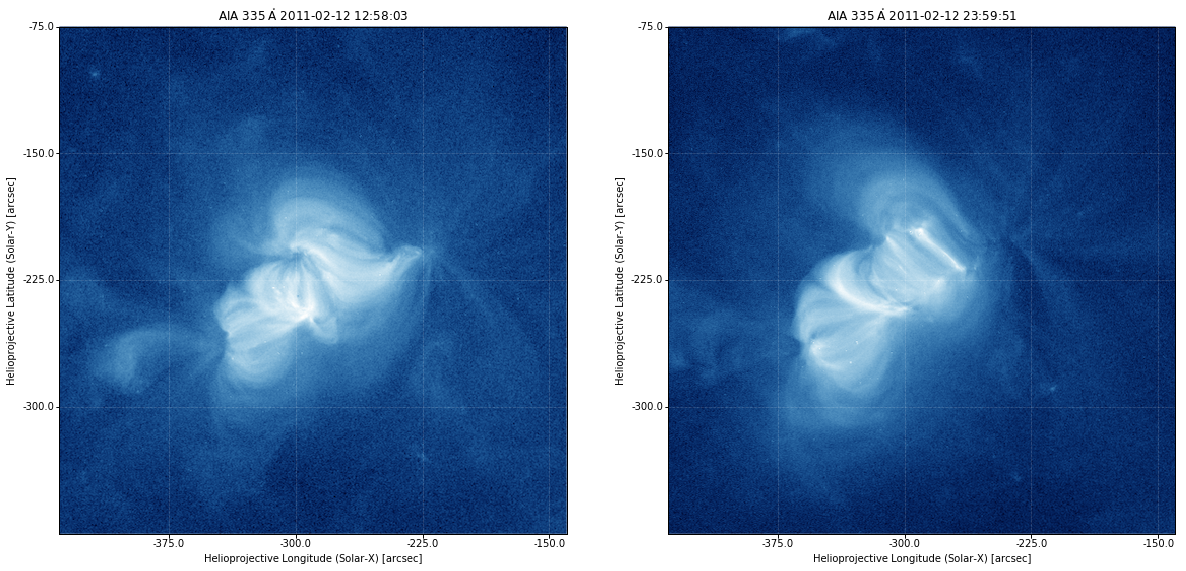

In [18]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T125803_335_cutout.fits')
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121,projection=m)
m.plot(axes=ax)
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T235951_335_cutout.fits')
ax = fig.add_subplot(122,projection=m)
m.plot(axes=ax)

In [ ]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/aia.lev1_euv_12s.20110212T120002Z.171.image_lev1.fits')
#map_f = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/aia.lev1_euv_12s.20110212T235950Z.171.image_lev1.fits')

In [ ]:
m_prep = m#aiaprep(m)

In [ ]:
m_prep.peek()
plt.show()

In [ ]:
m_prep_crop = m_prep.submap(SkyCoord(Tx=-600*u.arcsec,Ty=-600*u.arcsec,frame=m_prep.coordinate_frame),
                            SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=m_prep.coordinate_frame))

In [ ]:
m_prep_crop.peek()
plt.show()

In [ ]:
m_prep_rot = diffrot_map(m_prep, time=reference_date, rot_type='snodgrass')

In [ ]:
m_prep_rot.peek()
plt.show()

In [ ]:
m_prep_crop_rot = diffrot_map(m_prep_crop, time=reference_date, rot_type='snodgrass')
new_meta = m_prep_crop_rot.meta.copy()
rot_center = solar_rotate_coordinate(m_prep_crop.center, reference_date, rot_type='snodgrass')
new_meta['crval1'] = m_prep_crop.reference_coordinate.Tx.value + (m_prep_crop.center.Tx.value - rot_center.Tx.value)
new_meta['crval2'] = m_prep_crop.reference_coordinate.Ty.value + (m_prep_crop.center.Ty.value - rot_center.Ty.value)
m_prep_crop_rot = Map(m_prep_crop_rot.data, new_meta)

In [ ]:
m_prep_crop_rot_ar = m_prep_crop_rot.submap(SkyCoord(*cutout_left_corner,frame=m_prep_crop_rot.coordinate_frame),
                                            SkyCoord(*cutout_right_corner,frame=m_prep_crop_rot.coordinate_frame))
m_prep_crop_rot_ar.peek()
plt.show()

In [ ]:
m_prep_rot_crop = m_prep_rot.submap(SkyCoord(Tx=-600*u.arcsec,Ty=-600*u.arcsec,frame=m_prep_rot.coordinate_frame),
                                    SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec, frame=m_prep_rot.coordinate_frame))

In [ ]:
m_prep_rot_crop_ar = m_prep_rot_crop.submap(SkyCoord(*cutout_left_corner,frame=m_prep_rot_crop.coordinate_frame),
                                            SkyCoord(*cutout_right_corner,frame=m_prep_rot_crop.coordinate_frame))
m_prep_rot_crop_ar.peek()
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221,projection=m_prep_rot_crop)
m_prep_rot_crop.plot(axes=ax,title='Rotate, Crop')
ax = fig.add_subplot(222,projection=m_prep_crop_rot)
m_prep_crop_rot.plot(axes=ax,title='Crop, Rotate')
ax = fig.add_subplot(223,projection=m_prep_rot_crop_ar)
m_prep_rot_crop_ar.plot(axes=ax,title='Rotate, Crop AR')
ax = fig.add_subplot(224,projection=m_prep_crop_rot_ar)
m_prep_crop_rot_ar.plot(axes=ax,title='Crop, Rotate AR')

In [ ]:
reference_date

In [ ]:
m_no_rot = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/aia.lev1_euv_12s.20110212T153238Z.171.image_lev1.fits')

In [ ]:
m_no_rot_ar = m_no_rot.submap(SkyCoord(*cutout_left_corner,frame=m_no_rot.coordinate_frame),
                              SkyCoord(*cutout_right_corner,frame=m_no_rot.coordinate_frame))

In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=m_no_rot_ar)
m_no_rot_ar.plot(axes=ax,)